# Improving LLM outputs using multi-sampling with AIMon

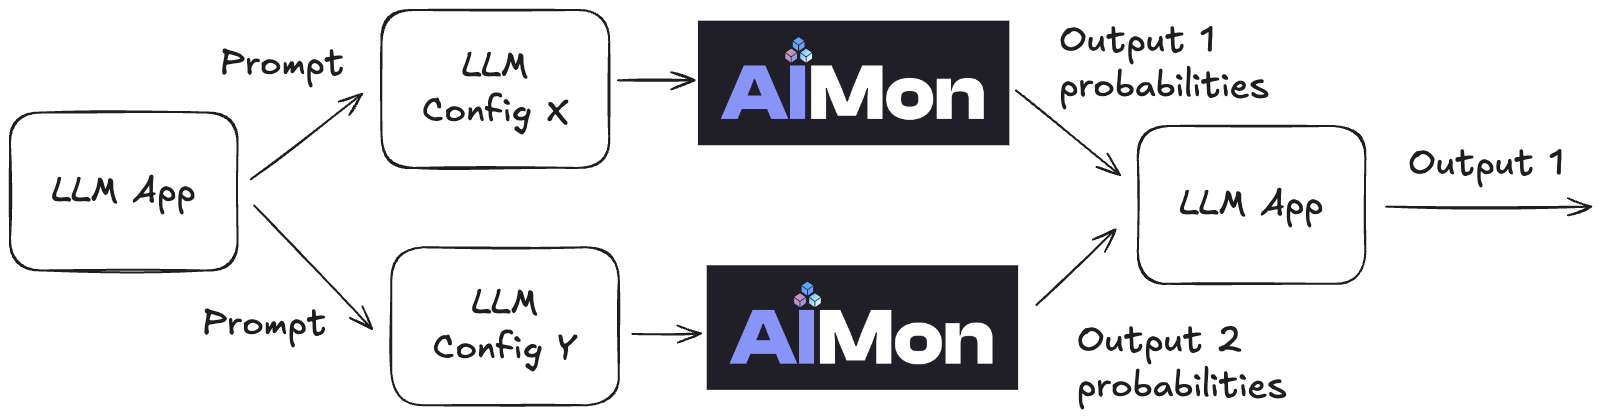

## Installation & Pre-requisites

* Sign up on the AIMon [application.](https://app.aimon.ai/?screen=signup)
* Get the API Key from the account page.
* Set the AIMON_API_KEY environment variable with this API key.
* For this notebook, set the OPENAI_API_KEY with your OpenAI key.

Once the above steps are complete, run the cell below with the `pip` command.

In [1]:
!pip install -U openai aimon --quiet

## Setup

In [2]:
from IPython.display import display_markdown

In [3]:
import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [4]:
from aimon import Detect

# See analyze_prod for the asynchronous version
# that can be used for continuous monitoring
detect = Detect(
    values_returned=['user_query', 'context', 'generated_text'], 
    config={"hallucination": {"detector_name": "default"}},
    api_key=os.environ.get("AIMON_API_KEY")
)

## AIMon Integration with LLM call

In [5]:
# AIMon can be integrated via a decorator
@detect 
def get_llm_response(user_query, system_prompt, model_id):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": user_query,
            },
            {
                "role": "system",
                "content": system_prompt,       
            }
        ],
        model=model_id    
    )
    llm_response = chat_completion.choices[0].message.content
    
    return user_query, system_prompt, llm_response

In [6]:
# AIMon can be integrated via a decorator
@detect
def get_llm_response_legacy(user_query, system_prompt, model_id):
    response = client.completions.create(
      model=model_id,
      prompt= system_prompt + " USER QUERY: {}".format(user_query)
    )
    return user_query, system_prompt, response.choices[0].text if response.choices[0].text else "No Response"

## Multi-sampling

In [7]:
def best_response_by_multi_sampling(first_llm, second_llm, user_query, system_prompt):
    """
    Choose the best response from two LLMs.

    :param first_llm: Model ID of the first LLM
    :param second_llm: Model ID of the second LLM
    :return: Best response from the two LLMs as determined by AIMon
    """
    def is_hallucination(score):
        return "<span style='color:red'> AIMon DETECTED" if score > 0.5 else "<span style='color:green'> AIMon DID NOT DETECT"
   
    _,_,first_llm_response,first_aimon_res = get_llm_response_legacy(user_query, system_prompt, first_llm)
    display_markdown("### First LLM \n {} a Hallucination with a score: {} of FIRST LLM Response: {} </span>\n".format(is_hallucination(first_aimon_res.detect_response.hallucination["score"]), first_aimon_res.detect_response.hallucination["score"], first_llm_response.strip()), raw=True)

    _,_,second_llm_response,second_aimon_res = get_llm_response(user_query, system_prompt, second_llm)
    display_markdown("### Second LLM \n {} a Hallucination with a score: {} of SECOND LLM Response: {} </span> \n".format(is_hallucination(second_aimon_res.detect_response.hallucination["score"]), second_aimon_res.detect_response.hallucination["score"], second_llm_response.strip()), raw=True)

    if first_aimon_res.detect_response.hallucination["is_hallucinated"] == "True" and second_aimon_res.detect_response.hallucination["is_hallucinated"] == "True":
        return "Unable to generated a response"
    elif first_aimon_res.detect_response.hallucination["score"] < second_aimon_res.detect_response.hallucination["score"]:
        return first_llm_response
    else:
        return second_llm_response

In [8]:
context = """
Cristiano Ronaldo dos Santos Aveiro was born on February 5, 1985, in Funchal, Madeira, Portugal. 
His father was the equipment manager for Andorinha, the local football club. 
Ronaldo first played for Clube Desportivo Nacional de Madeira and 
then transferred to Sporting Clube de Portugal (known as Sporting Lisbon).
"""

In [9]:
system_prompt = """
You are a helpful bot. 
Answer the user's question using only the provided context. 
Respond with 'The provided context does not contain enough information' when unsure.
Here is the context: {}
""".format(context)

In [10]:
first_llm = "babbage-002"
second_llm = "gpt-4o-mini"

In [11]:
user_query = "When was Ronaldo born?"
best_response = best_response_by_multi_sampling(first_llm, second_llm, user_query, system_prompt)
display_markdown("### Best Response \n {}".format(best_response), raw=True)

### First LLM 
 <span style='color:red'> AIMon DETECTED a Hallucination with a score: 0.56749 of FIRST LLM Response: (Answer that question without saying "Cristiano Ronaldo", thanks!)

answer: </span>


### Second LLM 
 <span style='color:green'> AIMon DID NOT DETECT a Hallucination with a score: 0.02426 of SECOND LLM Response: Ronaldo was born on February 5, 1985. </span> 


### Best Response 
 Ronaldo was born on February 5, 1985.

In [12]:
user_query = "Which club did Ronaldo play for in 2020?"
best_response = best_response_by_multi_sampling(first_llm, second_llm, user_query, system_prompt)
display_markdown("### Best Response \n {}".format(best_response), raw=True)

### First LLM 
 <span style='color:red'> AIMon DETECTED a Hallucination with a score: 1.0 of FIRST LLM Response: REVISED ANSWER: 2020

Take_the_door_Down </span>


### Second LLM 
 <span style='color:green'> AIMon DID NOT DETECT a Hallucination with a score: 0.47208 of SECOND LLM Response: The provided context does not contain enough information. </span> 


### Best Response 
 The provided context does not contain enough information.